## Linear Discriminant Analysis - Normal vs. Isolate

## Imports

In [1]:
import avn.dataloading as dataloading
import avn.acoustics as acoustics
import avn.plotting as plotting
import avn.segmentation as segmentation
import avn.syntax as syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import librosa
import os

from numpy.fft import fft, fftfreq
from scipy.signal.windows import hann
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

c:\Users\tkoch\anaconda3\envs\fresh_avn_dev\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Dataset

In [2]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

In [9]:
columns_to_drop = ['num_syllables', 'Condition', 'Bird_ID', 'entropy_rate']

In [10]:
all_feats_normal.groupby('Condition').count()

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,Bird_ID,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length
Condition,,,,,,,,,,,,,,,,,,,,,
FP1_KD_post_tut,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
FP1_KD_pre_tut,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
GFP,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Isolate,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
Pupil,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
Rockefeller-Pupil,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
Tutor,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


In [11]:
all_feats_normal = all_feats_normal.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

In [12]:
all_feats_normal[all_feats_normal.Condition == 'Isolate']['Bird_ID']

0      B145
1      B236
2      B258
8      G255
16     O144
17     O254
25     S132
34     Y453
93     B570
94     B613
95     O570
96     O642
97     R640
98     R643
99     S641
100    Y643
Name: Bird_ID, dtype: object

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [13]:
amplitude_features = all_feats_normal.columns[['Amplitude' in x for x in all_feats_normal.columns.tolist()]]

all_feats = all_feats_normal.drop(columns= amplitude_features)

## Normalize Feature Set

In [14]:
features_only = all_feats.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

scaler = StandardScaler()
scaler.fit(feature_mat)

StandardScaler()

In [15]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil'], dtype=object)

In [16]:
normal_and_iso = all_feats[~all_feats.Condition.isin([ 'FP1_KD_pre_tut'])]

In [17]:
features_only = normal_and_iso.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [18]:
class_dict = {'pre-deafening' : 0, 
              'post-deafening' : 1, 
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_and_iso.Condition]

## L1-Based Feature Selection

In [19]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [20]:
print(feature_mat_norm.shape)
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model_l1 = SelectFromModel(lsvc, prefit=True)
x_new = model_l1.transform(feature_mat_norm)
x_new.shape

(94, 43)


(94, 10)

Alright, so this cuts down our feature set from 43 to only 10 features. What are those features? 

In [21]:
feature_idx = [lsvc.coef_ != 0]
features = features_only.columns[np.squeeze(feature_idx)]

In [22]:
features

Index(['Goodness_mean_median', 'Entropy_mean_median', 'Entropy_mean_min',
       'Entropy_mean_max', 'Frequency_modulation_mean_min', 'Pitch_mean_max',
       'duration_CV_min', 'rhythm_entropy', 'syllable_duration_entropy',
       'syntax_entropy_rate'],
      dtype='object')

In [23]:
feature_weights = pd.DataFrame({'feature' : features_only.columns.values, 
                                'weight' : np.squeeze(lsvc.coef_)})
feature_weights['abs_weight'] = np.abs(feature_weights.weight)
feature_weights.sort_values('abs_weight', ascending=False).head(10)

,feature,weight,abs_weight
40,syntax_entropy_rate,0.218964,0.218964
34,duration_CV_min,0.200887,0.200887
36,rhythm_entropy,0.181522,0.181522
7,Entropy_mean_min,-0.157597,0.157597
14,Pitch_mean_max,0.072503,0.072503
8,Entropy_mean_max,-0.066087,0.066087
0,Goodness_mean_median,-0.060924,0.060924
6,Entropy_mean_median,-0.044510,0.044510
10,Frequency_modulation_mean_min,-0.033572,0.033572
38,syllable_duration_entropy,0.014948,0.014948


## Classification Accuracy with Reduced Feature Set

In [24]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(x_new, y)
X_transformed = model_LDA.transform(x_new)
X_transformed.shape

(94, 1)

In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

In [26]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=42)
scores = cross_val_score(model_LDA, X = x_new, y = y, scoring = 'accuracy', cv = cv, )

In [27]:
np.mean(scores)

0.9507407407407408

In [28]:
sem(scores)

0.011158053244902223

## Plotting Feature Weights

In [29]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(x_new, y)
X_transformed = model_LDA.transform(x_new)
X_transformed.shape

(94, 1)

In [30]:
model_LDA.coef_.flatten()

array([-1.27864547, -0.11022665, -1.51921373, -1.32942175, -0.90526331,
        1.09793419,  2.08671457,  1.84263642,  0.07285076,  2.36351753])

In [31]:
weights = pd.DataFrame(model_LDA.coef_.flatten(), index = features)
weights = weights.sort_values(by = 0, ascending= False)

In [32]:
plt.rcParams.update({'font.size': 8})

Text(0.5, 1.0, 'Typical vs. Isolate LDA Feature Weights')

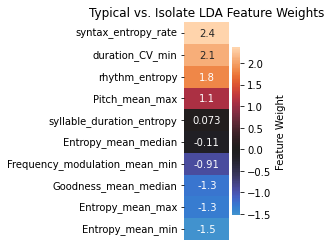

In [33]:
plt.figure(figsize=(1, 4))
sns.heatmap(weights, annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'})
plt.xticks([])
plt.title('Typical vs. Isolate LDA Feature Weights')
#plt.savefig('normal_vs_isolate_lda_feature_weights.svg', transparent = True)

In [34]:
pd.DataFrame(model_LDA.means_, columns = features, index = ['Typical', 'Isolate']).T

,Typical,Isolate
Goodness_mean_median,0.077675,-0.372372
Entropy_mean_median,0.241081,-0.998571
Entropy_mean_min,0.206881,-0.992245
Entropy_mean_max,0.149605,-0.673366
Frequency_modulation_mean_min,0.111304,-0.511733
Pitch_mean_max,-0.224121,0.885047
duration_CV_min,-0.361524,1.307518
rhythm_entropy,-0.309058,1.107766
syllable_duration_entropy,-0.285346,1.156145
syntax_entropy_rate,-0.372482,1.155776


# Plot Groups along LD1

## Load UTSW Dataset

In [35]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

In [36]:
all_feats.columns.to_frame().to_csv('LDA Features Table.csv')

## Load Wada Lab Deaf Birds

In [37]:
all_feats_deaf = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\wada_birds_all_feats.csv').drop(columns = 'Unnamed: 0')

In [38]:
all_feats_deaf

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length,Condition
0,0.117747,0.114967,0.121071,2155.357576,2109.599981,2867.423096,-3.266155,-3.448087,-3.060742,61.694346,...,-0.142866,6.848818,0.795698,0.679239,2.085816,0.695272,7,1.180929,0.341734,deaf_120
1,0.138719,0.134799,0.143075,1916.063608,1905.271892,1967.627065,-3.067501,-3.118677,-2.831167,60.048020,...,-0.420613,4.462123,0.623511,0.596916,1.073634,0.415338,5,6.325758,0.855042,deaf_300
2,0.120487,0.115469,0.141427,1761.408783,1563.806841,3297.943880,-3.145204,-3.359798,-2.939603,56.802061,...,-0.186091,4.453035,0.661636,0.792669,2.322015,0.671213,10,2.047170,0.529954,deaf_120
3,0.138086,0.123512,0.146133,1756.748116,1433.786306,2007.303591,-3.356677,-3.532446,-2.834024,56.994473,...,-0.890552,4.523146,0.439880,0.786990,1.312251,0.413969,8,1.200000,0.381881,deaf_300
4,0.114786,0.104775,0.116830,1789.762898,1485.763158,2337.077138,-3.683179,-3.889325,-3.563164,54.013514,...,-0.229416,2.829038,0.684722,0.851385,2.736651,0.823814,9,1.807692,0.555234,deaf_120
5,0.140029,0.123126,0.163307,1837.666285,1569.842809,2464.989868,-2.950556,-3.258490,-2.657295,52.208152,...,-0.814188,3.042721,0.430952,0.581725,1.596453,0.503625,8,2.497939,0.711100,deaf_300
6,0.110085,0.102550,0.135041,2305.491632,1474.451575,3660.457968,-2.612077,-2.928364,-2.373068,52.716926,...,-0.145907,12.336573,0.740859,0.862666,2.236685,0.646547,10,1.750000,0.473804,deaf_120
7,0.131318,0.123017,0.143566,1944.922759,1834.077485,2438.096988,-2.865155,-3.101042,-2.670985,57.502545,...,-0.212056,4.376186,0.636782,0.828545,1.416925,0.504719,6,2.524590,0.623647,deaf_300
8,0.118705,0.113045,0.124365,1804.720076,1590.400913,2019.039239,-3.079158,-3.291822,-2.866493,49.660063,...,-0.176262,7.477644,0.593052,0.866371,0.778098,0.490925,2,5.219178,0.842512,deaf_120
9,0.170568,0.128027,0.179388,1705.981868,1661.570229,1956.193094,-3.513520,-3.598754,-3.245168,58.378313,...,-0.367510,4.838005,0.419097,0.669968,0.814732,0.350886,4,6.861111,0.639381,deaf_300


In [39]:
all_feats_deaf['rhythm_entropy'] = 10**all_feats_deaf.rhythm_entropy

## Merge Datasets

In [40]:
all_feats = pd.concat([all_feats_normal, all_feats_deaf])

In [41]:
all_feats.to_csv('AVN_features_LDA.csv')

In [42]:
all_feats = all_feats.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [41]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

## Normalize Dataset

In [42]:
normal_iso_deaf = all_feats[~all_feats.Condition.isin([ 'deaf_120'])]

In [43]:
features_only = normal_iso_deaf.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [44]:
X_feat_subset= model_l1.transform(feature_mat_norm)
LD1_pred = model_LDA.transform(X_feat_subset)

In [45]:
lda_df = pd.DataFrame({'coord_x' : np.squeeze(LD1_pred), 
                        'condition' : normal_iso_deaf.Condition, 
                         'Bird_ID' : normal_iso_deaf.Bird_ID})

In [46]:
group_dict = {'deaf_300' : "Deaf", 
              'sham-deafening' : "Sham Deafening", 
              'deaf_120' : "Deaf Unstable",
              'FP1_KD_post_tut' : 'Typical UTSW', 
              'GFP' : 'Typical UTSW', 
              'Pupil' :  'Typical UTSW', 
              'Tutor' : 'Typical UTSW', 
              'Rockefeller-Pupil': 'Typical Rockefeller',
              'Isolate' : 'Isolate', 
              'FP1_KD_pre_tut' : 'FP1 KD'}
lda_df['Group'] = [group_dict[x] for x in lda_df.condition]

In [47]:
lda_df.head(2)

,coord_x,condition,Bird_ID,Group
0,-2.409567,Isolate,B145,Isolate
1,-6.381066,Isolate,B236,Isolate


In [48]:
lda_df.Group = lda_df.Group.astype('category').cat.set_categories(['Isolate', 'FP1 KD', 'Deaf', 'Sham Deafening', 'Typical UTSW', 'Typical Rockefeller'], ordered = True)

Text(0.5, 1.0, 'Isolate vs. Typical LDA')

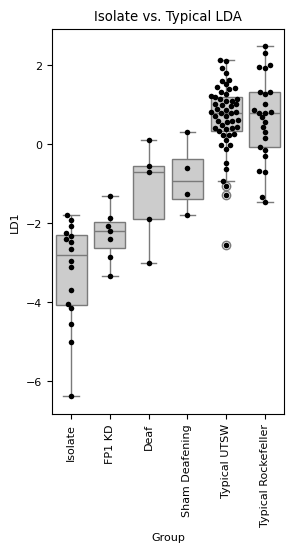

In [49]:
plt.figure(figsize = (3, 5))
sns.boxplot(data = lda_df, y = 'coord_x', x = 'Group', color = '0.8')
sns.swarmplot(data = lda_df, y = 'coord_x', x = 'Group', color = 'black', legend = False, s = 4)
plt.ylabel('LD1')
plt.xticks(rotation = 90)
plt.title('Isolate vs. Typical LDA')

In [50]:
plt.rcParams.update({'font.size': 8})

In [54]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [58]:
palette = [sns.color_palette()[0], sns.color_palette()[2],sns.color_palette()[7],sns.color_palette()[5], 
           sns.color_palette()[1], 'crimson' ]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 'crimson']

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


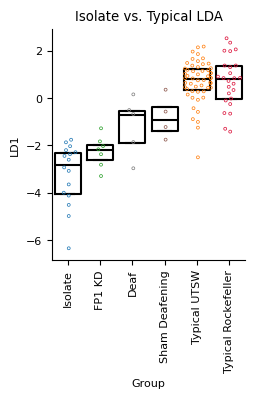

In [70]:
plt.figure(figsize = (2.5, 3))
sns.boxplot(data = lda_df, y = 'coord_x', x = 'Group', fill = False, color = 'black', 
            fliersize=0, whis= 0, 
            legend = False)
sns.swarmplot(data = lda_df, y = 'coord_x', x = 'Group', hue = 'Group', legend = False, s = 4, 
              palette = palette, marker = '$\circ$')
plt.ylabel('LD1')
plt.xticks(rotation = 90)
plt.title('Isolate vs. Typical LDA')
sns.despine()
plt.savefig('isolate vs typical LD1 all groups.svg', transparent = True)

In [25]:
lda_df.groupby('Group').count()

,condition,Bird_ID
Group,,
Isolate,16,16
FP1 KD,7,7
Deaf,5,5
Sham Deafening,4,4
Typical UTSW,53,53
Typical Rockefeller,25,25
